In [63]:
# import the usual libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import datetime

# import tools for time series analysis
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

In [41]:
# load data
trends_df = pd.read_csv('../assets/google_trends_dengue_cases.csv', index_col=0)
weather_df = pd.read_csv('../assets/cleaned_comb_changi_weather.csv')

In [26]:
weather_df.head()

,type_dengue,date,year,month,number,Year,Month,Day,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),Max Wind Speed (km/h),week
0,Dengue,2014-01-06,2014,1,436.0,2014,1,6,31.2,10.0,10.8,11.6,25.3,27.1,23.9,6.1,25.6,2
1,DHF,2014-01-06,2014,1,1.0,2014,1,6,31.2,10.0,10.8,11.6,25.3,27.1,23.9,6.1,25.6,2
2,Dengue,2014-01-13,2014,1,479.0,2014,1,13,0.0,0.0,0.0,0.0,26.9,30.3,25.4,14.6,40.0,3
3,DHF,2014-01-13,2014,1,0.0,2014,1,13,0.0,0.0,0.0,0.0,26.9,30.3,25.4,14.6,40.0,3
4,Dengue,2014-01-20,2014,1,401.0,2014,1,20,0.0,0.0,0.0,0.0,25.7,29.1,23.6,11.7,38.2,4


In [25]:
weather_df.shape

# drop dhf rows, and the rest of the columns before merging with trends

(522, 18)

In [42]:
weather_df = weather_df[weather_df['type_dengue'] == 'Dengue']

In [43]:
weather_df.shape

(261, 18)

In [44]:
trends_df.head()

,date,year,month,week,dengue_search,dengue_fever_search,dengue_symptoms_search,rashes_search,vomiting_search,eye_pain_search,joint_pain_search,fever_search,wolbachia_search,headache_search,nausea_search,fogging_search,insect_repellent_search,mosquito_search,dengue_sum
0,2014-06-01,2014,1,1,44,61,18,67,43,30,27,73,0,22,9,0,1,5,437.0
1,2014-13-01,2014,1,2,38,55,14,73,38,0,26,66,2,25,11,0,3,5,479.0
2,2014-20-01,2014,1,3,31,46,13,60,52,12,13,80,0,27,8,0,3,4,401.0
3,2014-27-01,2014,1,4,23,33,8,57,39,31,0,64,0,25,12,0,3,6,336.0
4,2014-03-02,2014,2,5,28,38,6,56,31,0,7,72,0,22,8,0,3,8,234.0


In [45]:
trends_df.shape

(261, 19)

In [47]:
trends_df.isnull().sum()

date                       0
year                       0
month                      0
week                       0
dengue_search              0
dengue_fever_search        0
dengue_symptoms_search     0
rashes_search              0
vomiting_search            0
eye_pain_search            0
joint_pain_search          0
fever_search               0
wolbachia_search           0
headache_search            0
nausea_search              0
fogging_search             0
insect_repellent_search    0
mosquito_search            0
dengue_sum                 1
dtype: int64

In [49]:
merged_df = pd.concat([weather_df.reset_index(drop=True), trends_df.reset_index(drop=True)], axis=1, names=['date', 'year', 'month', 'week'])

In [51]:
# drop first 8 columns
merged_df = merged_df.iloc[: , 8:]

/var/folders/t4/n89gfp4s10b4j476kq4xh2p00000gn/T/ipykernel_32167/3431215629.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = merged_df.corr()


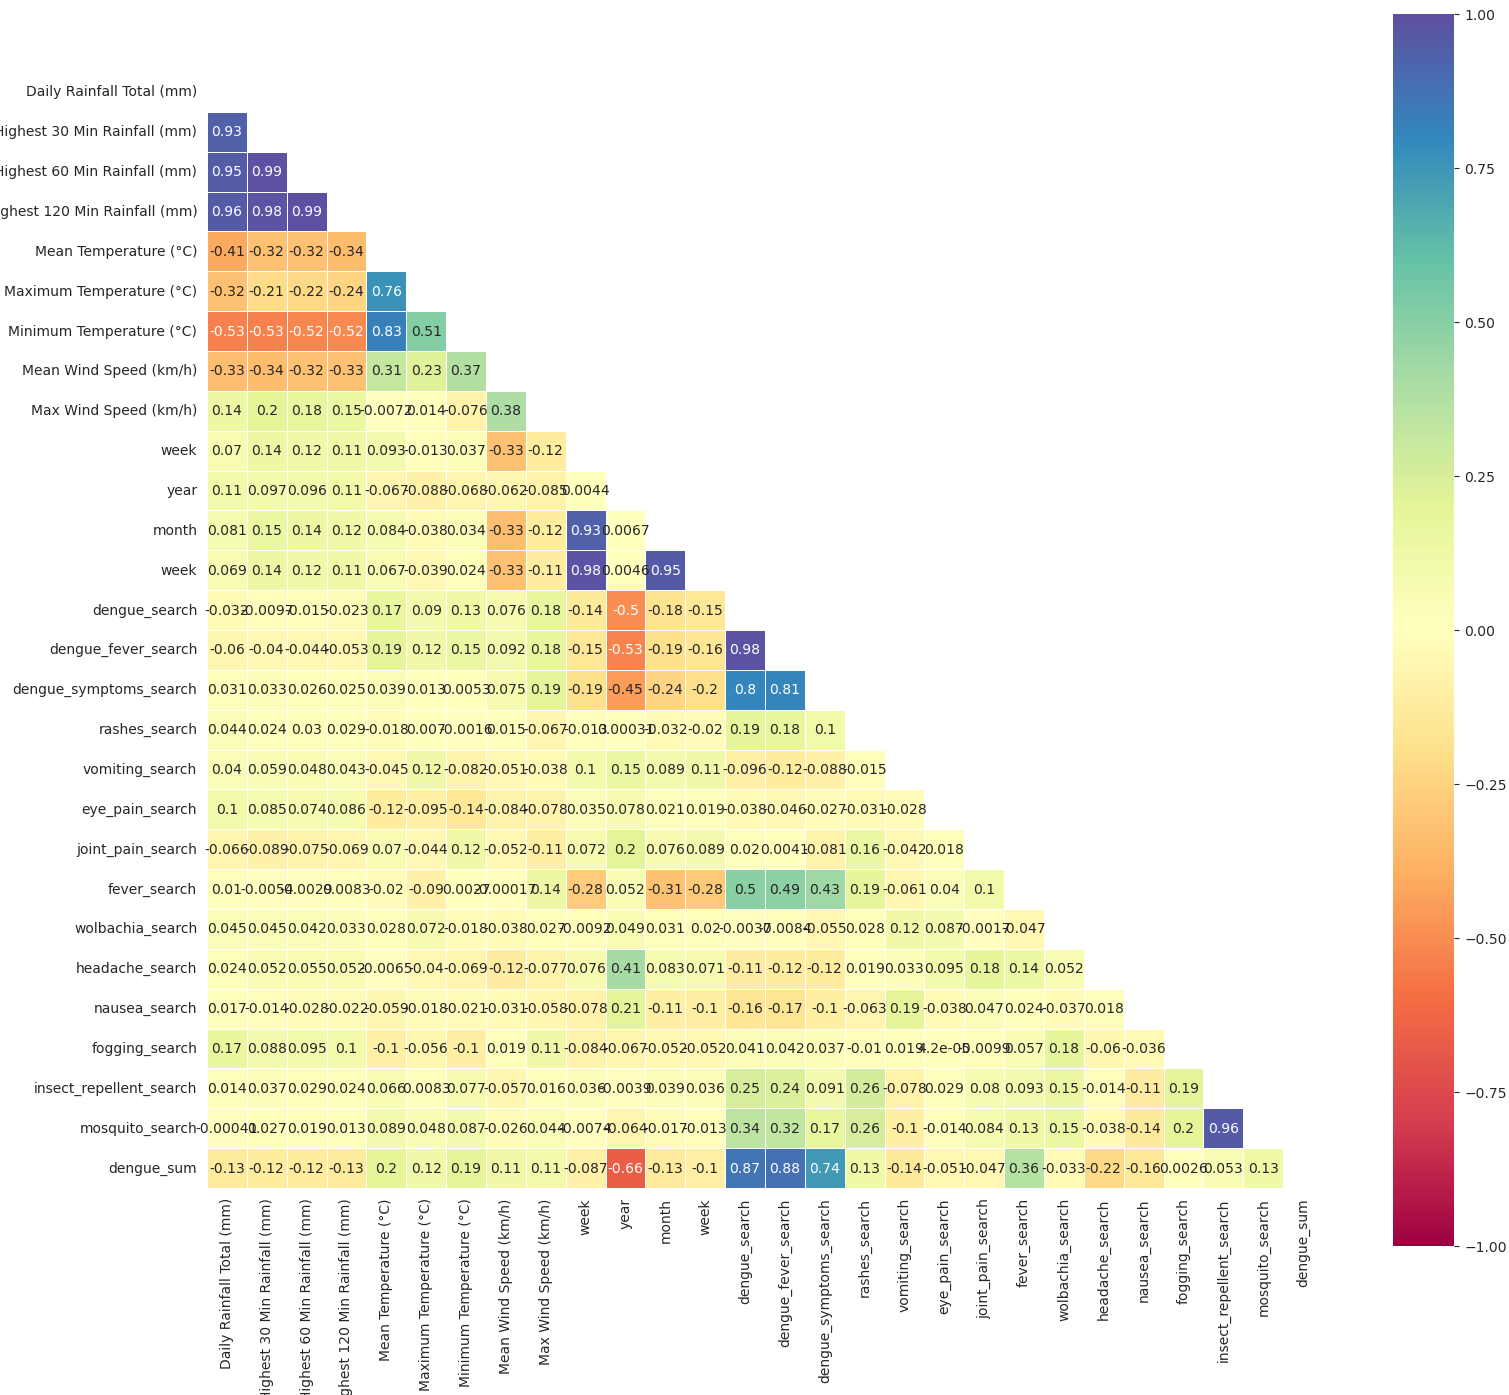

In [55]:
# Get correlation of the remaining features after cleaning
plt.figure(figsize = (18,16))

corr = merged_df.corr()

# Set up mask to be "True" in the upper triangle. this is to reduce the number of 'squares' seen in the correlation heatmap
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Plot our correlation heatmap, while masking the upper triangle to be white.
with sns.axes_style("white"):
    sns.heatmap(corr, mask = mask, square = True, annot = True, vmin = -1, vmax = 1, linewidths = .5, cmap='Spectral')

In [ ]:
merged_df.corr()

In [ ]:
merged_df = merged_df.drop(['week'], axis=1)

In [ ]:
# rearrange the columns

merged_df_columns = ['date', 'year', 'month', 'week', 'dengue_search', 'dengue_fever_search','dengue_symptoms_search',  
                  'rashes_search', 'vomiting_search', 'eye_pain_search', 'joint_pain_search',
                 'fever_search', 'wolbachia_search', 'headache_search', 'nausea_search', 'fogging_search',
                 'insect_repellent_search','mosquito_search', 'dengue_sum']

merged_df = merged_df[merged_df_columns]

In [57]:
def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(18,9))
    
    # Iterate through each column name.
    for col in cols:
            
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col])
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    plt.yticks(fontsize=18)
    plt.xticks(df.index[0::steps], fontsize=18);

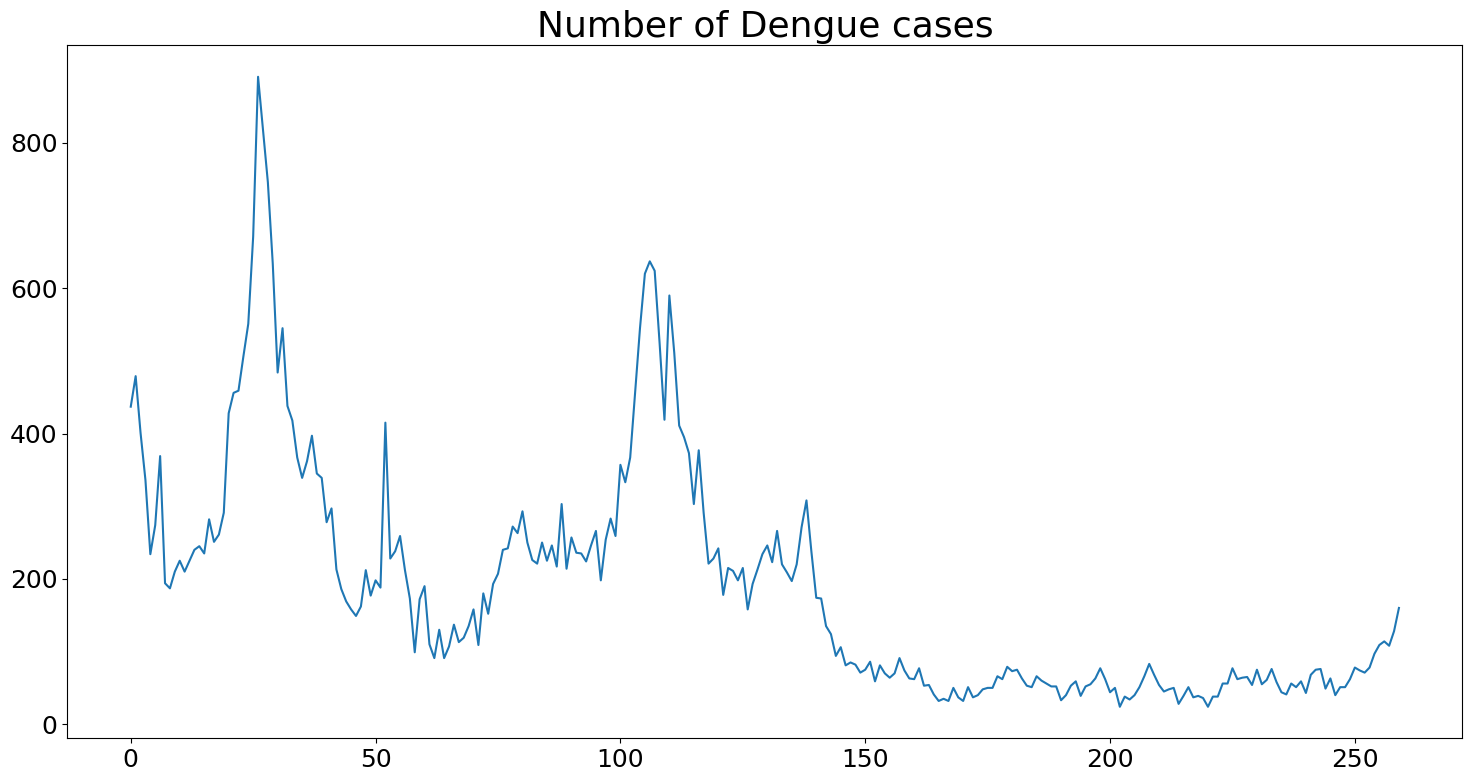

In [59]:
# check if dengue cases is stationary.
plot_series(merged_df,
            ['dengue_sum'],
            title = "Number of Dengue cases",
            steps = 50)

**Observation**:Dengue cases data does not look stationary. 

In [61]:
# Create first_diff_temp 

merged_df['first_diff_dengue'] = merged_df['dengue_sum'].diff()
#df['second_diff_temp'] = df['avg_temp'].diff().diff()

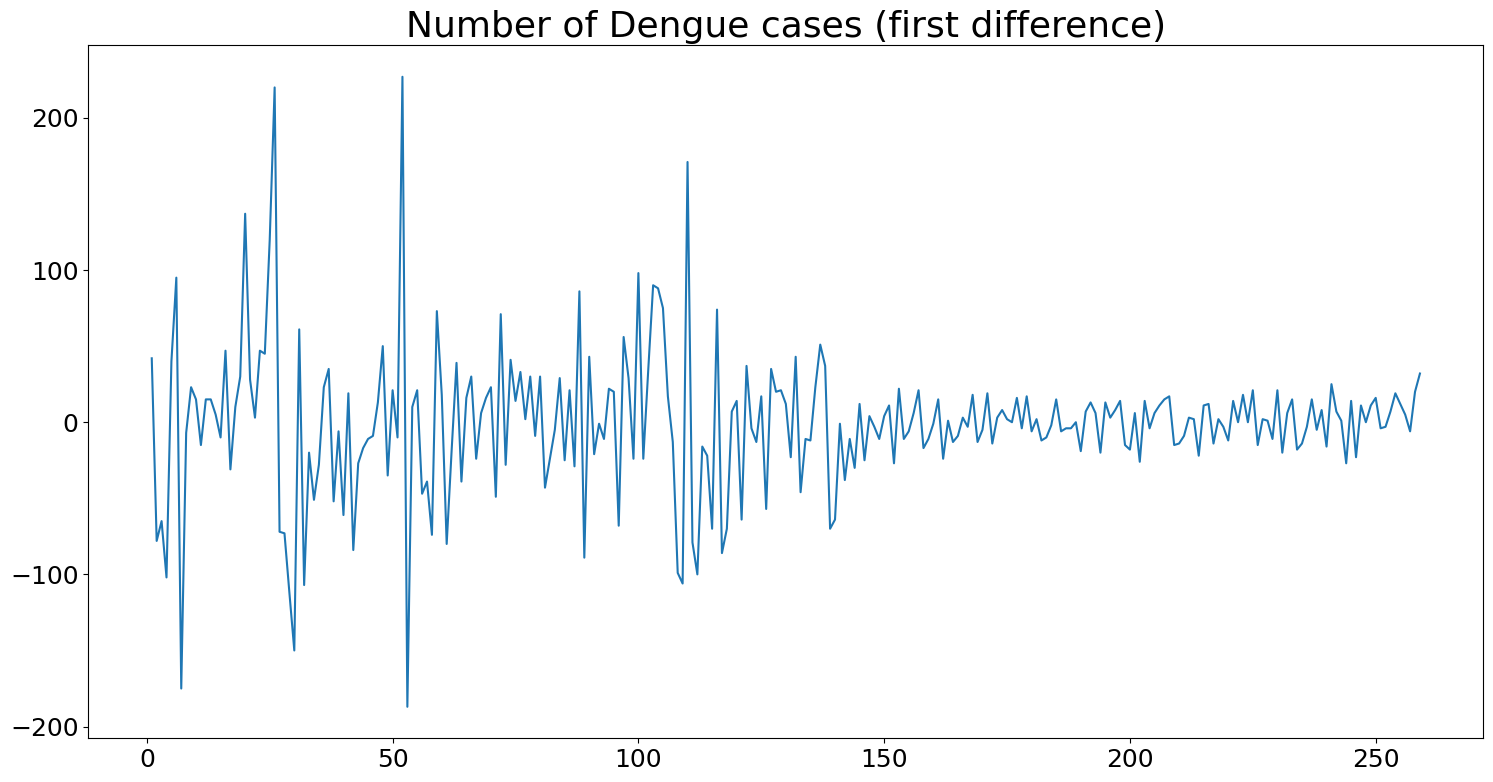

In [62]:
plot_series(merged_df,
            ['first_diff_dengue'],
            title = "Number of Dengue cases (first difference)",
            steps = 50)

**Observation**: The first difference of dengue cases data looks stationary. I will double check this with Augmented Dickey Fuller test

In [66]:
merged_df['first_diff_dengue'].isnull().sum()

2

In [67]:
merged_df = merged_df.dropna()

In [68]:
adfuller(merged_df['first_diff_dengue'])

(-17.571217739041405,
 4.050600861026794e-30,
 0,
 258,
 {'1%': -3.455952927706342,
  '5%': -2.8728086526320302,
  '10%': -2.572774990685656},
 2540.720746355989)

**Observation**: the p-value is 4.05e-30, which is a very small number. This means that the null hypothesis of the augmented dickey-fuller test is rejected. The first difference is shown to be stationary

In [ ]:
# now, we fit the data into an ARIMA model / other models 


In [ ]:
# select features 